In [17]:
import os
import sys
import numpy as np
import utilities as utils
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats
from collections import Counter
import seaborn as sns

## Model predictions (BERT)

In [18]:
conll03_config = "b1.0-conll03-large"

!ls -l results/{conll03_config}/checkpoint/
!ls -l configs/baselines

total 1303188
-rw-r--r-- 1 dwija dwija       1760 Jun 15 10:17 config.json
-rw-r--r-- 1 dwija dwija 1334453533 Jun 15 10:17 pytorch_model.bin
-rw-r--r-- 1 dwija dwija       1977 Jun 15 10:17 training_meta.bin
total 4
-rw-r--r-- 1 dwija dwija 1884 Jun 15 10:17 b1.0-conll03-large.json


I saved the best predictions of the model in the checkpoint folder (check them out `ls results/b1.0-conll03-large/*.bin`). You can load the predictions along with the lables from those binary files:

In [19]:
!ls results/b1.0-conll03-large/*.bin

results/b1.0-conll03-large/dev_best_preds.bin
results/b1.0-conll03-large/dev_preds_across_epochs.bin
results/b1.0-conll03-large/test_best_preds.bin
results/b1.0-conll03-large/train_preds_across_epochs.bin


In [20]:
import torch
import json
from utilities import EpochStats

conll03_args = utils.load_args(default_config=f"configs/baselines/{conll03_config}.json")

#f" loads a file like object so this one is loading the model's predictions
test_pred_stats = torch.load(f"results/{conll03_config}/test_best_preds.bin")
test_pred_stats.print_classification_report(conll03_args.data.label_scheme)

classes      precision    recall    f1-score    support
---------  -----------  --------  ----------  ---------
LOC             92.679    93.345      93.011       1668
MISC            82.464    81.054      81.753        702
ORG             85.125    91.993      88.426       1661
PER             96.669    95.114      95.885       1617

macro avg       90.330    91.926      91.086       5648
micro avg       90.202    91.926      91.056       5648



Or you can load the predictions, convert them to label (using label_scheme), and then load the actual data (e.g., from the data folder) and align them to check the results. Both ways are equivalent:

In [21]:
from seqeval.metrics import f1_score, precision_score, recall_score
from seqeval.metrics import classification_report

conll03_bert_pred = {
    "ner": test_pred_stats._map_to_labels(conll03_args.data.label_scheme)[1]
}

#conll_gold = test_pred_stats._map_to_labels(conll03_args.data.label_scheme)[0]  
conll03_test = os.path.join(conll03_args.data.directory, "test.txt")
conll03_test = utils.read_conll(conll03_test, columns={'txt': 0, 'ner': 1})

utils.printcr(
    utils.report2dict(
        classification_report(conll03_test['ner'], conll03_bert_pred['ner'], digits=5)
    )
)


classes      precision    recall    f1-score    support
---------  -----------  --------  ----------  ---------
LOC             92.679    93.345      93.011       1668
MISC            82.464    81.054      81.753        702
ORG             85.125    91.993      88.426       1661
PER             96.669    95.114      95.885       1617

macro avg       90.330    91.926      91.086       5648
micro avg       90.202    91.926      91.056       5648



In [22]:
cm_gold=[]
cm_pred=[]

for sublist in conll03_test['ner']:
    for item in sublist:
        cm_gold.append(item)
        
for sublist in conll03_bert_pred['ner']:
    for item in sublist:
        cm_pred.append(item)       

In [32]:
cm_classes=sorted(set(cm_gold))
cf_matrix=skm.confusion_matrix(cm_gold,cm_pred,cm_classes)
cf_matrix= pd.DataFrame(cf_matrix)
cf_matrix.columns=cm_classes
cf_matrix.index=cm_classes
cf_matrix

,B-LOC,B-MISC,B-ORG,B-PER,I-LOC,I-MISC,I-ORG,I-PER,O
B-LOC,1562,24,59,6,2,1,7,1,6
B-MISC,27,585,49,5,1,5,1,0,29
B-ORG,46,18,1553,12,0,0,9,0,23
B-PER,13,0,40,1543,0,0,1,7,13
I-LOC,0,0,0,0,243,0,9,2,3
I-MISC,1,5,1,0,10,153,24,1,21
I-ORG,2,0,6,0,28,8,767,5,19
I-PER,0,2,0,1,1,0,8,1144,0
O,15,46,77,18,11,46,38,3,38069


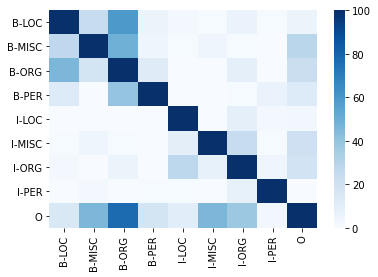

In [33]:
sns.heatmap(cf_matrix, vmin=0, vmax=100, cmap='Blues')
#disp = skmplot_confusion_matrix(X=cm_gold,y_true=cm_pred,display_labels=cm_classes,cmap=plt.cm.Blues)
#disp.ax_.set_title(title)
#print(title)
#print(disp.confusion_matrix)
#['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

## Load model to predict

In [9]:
import os
import torch
import transformers
from transformers import BertConfig, BertForTokenClassification, BertTokenizer
from nets import NERModel

def load_model(checkpoint_dir, args):
    tokenizer = BertTokenizer.from_pretrained(args.model.pretrained)
    model = NERModel.from_pretrained(checkpoint_dir)
    model.eval()
    labels = args.data.label_scheme
    return model, tokenizer, labels

model, tokenizer, index2label = load_model(f"results/{conll03_config}/checkpoint/", conll03_args)

Define the `predict` function that uses the previously-loaded models:

In [10]:
def predict(tokens, verbose=False):
    # Including special tokens
    input_ids = []
    label_msk = []
    
    for token in tokens:
        bert_tokenized = tokenizer.encode(token, add_special_tokens=False)
        if len(bert_tokenized) == 1:
            input_ids.extend(bert_tokenized)
            label_msk.append(1)
        else:
            input_ids.extend(bert_tokenized)
            label_msk.extend([1] + [0] * (len(bert_tokenized) - 1))
    
    input_ids = torch.tensor([ [tokenizer.cls_token_id] + input_ids ])
    label_msk = torch.tensor([ [0] + label_msk ])
    
    if verbose:
        print(tokens)
        print(tokenizer.tokenize(' '.join(tokens)))
    
    assert input_ids.shape == label_msk.shape
    
    with torch.no_grad():
        losses, scores = model(input_ids, attention_mask=None, token_type_ids=None)
        scores = scores[label_msk == 1]
        logits = torch.softmax(scores, dim=-1)
        classes = torch.argmax(logits, dim=-1).view(-1)
        preds = [index2label[ix] for ix in classes] 
    return preds

## Predict using the model

We can try the fine-tuned modal now:

In [11]:
print(predict("Barack Obama was a president".split()))
print(predict("Gustavo plays at the park".split()))
print(predict("Solorio's speech was inspired".split()))

['B-PER', 'I-PER', 'O', 'O', 'O']
['B-PER', 'O', 'O', 'O', 'O']
['B-ORG', 'O', 'O', 'O']


In [11]:
def predict_many(sentences):
    predictions = []
    for s in sentences:
        predictions.append(predict(s))
    return predictions
    
predict_many([
    'Barack Obama was a president'.split(),
    'barack obama was a president'.split(),
    'bArAcK oBaMa was a president'.split(),
    'Barack Obama'.split(),
    'barack obama'.split(),
    'bArAcK oBaMa'.split(),
])

[['B-PER', 'I-PER', 'O', 'O', 'O'],
 ['B-PER', 'I-PER', 'O', 'O', 'O'],
 ['B-ORG', 'I-ORG', 'O', 'O', 'O'],
 ['B-PER', 'I-PER'],
 ['O', 'O'],
 ['B-ORG', 'O']]

In [12]:
predict_many([
    'China will be present at the Winter Olympics'.split(),
    'China will be present at the winter olympics'.split(),
    'china will be present at the Winter Olympics'.split(),
    'Russia will be present at the Winter Olympics'.split(),
    'The USA will be present at the Winter Olympics'.split(),
    'the usa will be present at the Winter Olympics'.split(),
    'USA will be present at the Winter Olympics'.split(),
])

[['B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC'],
 ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC'],
 ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC'],
 ['O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC'],
 ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC']]

In [13]:
predict_many([
    'I will not go Outside today'.split(),
    'I will not go to the outside today'.split(),
    'I will not go to the Outside today'.split(),
    'I will not go to the Outside Today'.split(),
])

[['O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [14]:
predict_many([
    'Microsoft’s new Edge browser will be built into Windows 10 in the update to be released in August'.split(),
    'julia will be built into Windows 10 again later this year'.split(),
    'Julia will be built into Windows 10 again later this year'.split(),
])

[['B-ORG',
  'O',
  'B-MISC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-MISC',
  'I-MISC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O'],
 ['B-PER', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O']]